In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from matplotlib import pyplot as plt

In [2]:
trainLabels = pd.read_csv("typing-challenge/task2/task2-keystrokes-12users-train-labels.txt", header=None)
trainLabels.columns = ["record_id","user_id_train"]
trainLabels.shape
n_neigh = 7

In [3]:
trueLabels = pd.read_csv("typing-challenge/task2/sol/true_labels.csv", header=None)
trueLabels.columns = ["record_id","usedInTest", "record_id_true"]
trueLabels = trueLabels.loc[trueLabels.usedInTest == 1]
trueLabels

,record_id,usedInTest,record_id_true
0,0,1,1
1,1,1,9
2,2,1,5
5,5,1,5
7,9,1,3
...,...,...,...
474,534,1,1
479,539,1,6
483,543,1,4
485,545,1,8


In [4]:
valLabels = pd.read_csv("typing-challenge/task2/sol/true_labels.csv", header=None)
valLabels.columns = ["record_id","usedInTest", "record_id_true"]
valLabels = valLabels.loc[valLabels.usedInTest == 0]
valLabels

,record_id,usedInTest,record_id_true
3,3,0,6
4,4,0,10
6,6,0,8
8,10,0,11
9,11,0,2
...,...,...,...
480,540,0,7
481,541,0,6
482,542,0,8
484,544,0,6


In [5]:
def process_knn(addr,featureAddress, trainLabels, trueLabels, n_neigh, meanSub, emptySub, storeSolution=False):

    df = pd.DataFrame(np.load(addr+featureAddress))
    df.index = df.index-1
    if meanSub:
        df = df-df.iloc[0,:] # removing empty image
    if emptySub:
        df = df-df.mean(axis=0) # removing mean image
    dfY = df.join(trainLabels.set_index("record_id"),how="inner")
    
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=n_neigh,weights="distance", metric="cosine")
    neigh.fit(dfY.iloc[:,:-1],dfY.iloc[:,-1:]["user_id_train"])
    #res = neigh.predict(df)
    resDF = pd.DataFrame(neigh.predict(df))
    resDF.index = resDF.index-1 #Empty file is here as well
    resDF.columns = ["record_id_predicted"]
        
    jointDF = resDF
    jointDF = jointDF.join(trueLabels.set_index("record_id"), how="inner")

    evalRes = (jointDF.record_id_predicted == jointDF.record_id_true).sum() / (jointDF.record_id_predicted == jointDF.record_id_true).count()
    print(evalRes, featureAddress, n_neigh, meanSub, emptySub)
    if storeSolution:
        fname = featureAddress.replace(".npy","")
        faddr = addr.replace("visualizations_task2_extracted/task2_visualizations2_","").replace("/","")
        
        rStore = resDF["record_id_predicted"]
        rStore = rStore.iloc[1:]        
        rStore.to_csv("task2_KNN_"+faddr+"_"+fname+"_"+str(n_neigh)+"_"+str(meanSub)+"_"+str(emptySub)+".csv", header=False)
  
    return evalRes

In [6]:
from os import listdir
from os.path import isfile, join
def process_source():
    addr_base = "visualizations_task2_extracted/task2_visualizations2_"
    #addr_ext = "blacks_extracted/"
    #addr_ext = "extracted/"
    #addr_ext = "inverted_extracted/"
    #addr_ext = "inverted2_extracted/"
    #addr_ext = "inverted3_extracted/"

    res = []
    for addr_ext in ["extracted/","inverted_extracted/","inverted2_extracted/","inverted3_extracted/","blacks_extracted/"]:
        addr = addr_base + addr_ext 
        onlyfiles = [f for f in listdir(addr) if isfile(join(addr, f))]
        for n_neigh in [1,3,5,7]:
            for meanSub in [True]:
                for emptySub in [False]:
                    for f in onlyfiles:    
                        evalRes = process_knn(addr,f, trainLabels, valLabels, n_neigh, meanSub, emptySub)
                        res.append([f,n_neigh, meanSub, emptySub, evalRes, addr_ext])

    resDF = pd.DataFrame(res)
    resDF.columns = ["feature_set","n_neigh","meanSub","emptySub","results","data"]
    #resDF.sort_values("results").tail(50)  
    return resDF

In [7]:
df = process_source()

0.4166666666666667 EfficientNetExtractor_2_.npy 1 True False
0.5833333333333334 ImageGPTExtractor_medium_.npy 1 True False
0.7301587301587301 RGBHistogramExtractorGrid_256_1.npy 1 True False
0.3968253968253968 RGBHistogramExtractorGrid_256_2.npy 1 True False
0.7222222222222222 RGBHistogramExtractorGrid_32_1.npy 1 True False
0.43253968253968256 RGBHistogramExtractorGrid_32_2.npy 1 True False
0.7222222222222222 RGBHistogramExtractorGrid_64_1.npy 1 True False
0.4087301587301587 RGBHistogramExtractorGrid_64_2.npy 1 True False
0.6626984126984127 RGBHistogramExtractor_256_.npy 1 True False
0.6785714285714286 RGBHistogramExtractor_64_.npy 1 True False
0.5753968253968254 ViTExtractor_large_.npy 1 True False
0.5476190476190477 VLADExctractor__.npy 1 True False
0.4087301587301587 EfficientNetExtractor_2_.npy 3 True False
0.5595238095238095 ImageGPTExtractor_medium_.npy 3 True False
0.7063492063492064 RGBHistogramExtractorGrid_256_1.npy 3 True False
0.36507936507936506 RGBHistogramExtractorGrid_2

0.6785714285714286 RGBHistogramExtractor_64_.npy 5 True False
0.5079365079365079 ViTExtractor_large_.npy 5 True False
0.4642857142857143 VLADExctractor__.npy 5 True False
0.3968253968253968 EfficientNetExtractor_2_.npy 7 True False
0.5674603174603174 ImageGPTExtractor_medium_.npy 7 True False
0.6587301587301587 RGBHistogramExtractorGrid_256_1.npy 7 True False
0.31746031746031744 RGBHistogramExtractorGrid_256_2.npy 7 True False
0.6865079365079365 RGBHistogramExtractorGrid_32_1.npy 7 True False
0.36507936507936506 RGBHistogramExtractorGrid_32_2.npy 7 True False
0.6825396825396826 RGBHistogramExtractorGrid_64_1.npy 7 True False
0.3253968253968254 RGBHistogramExtractorGrid_64_2.npy 7 True False
0.30158730158730157 RGBHistogramExtractorGrid_64_3.npy 7 True False
0.6150793650793651 RGBHistogramExtractor_256_.npy 7 True False
0.6190476190476191 RGBHistogramExtractor_64_.npy 7 True False
0.5198412698412699 ViTExtractor_large_.npy 7 True False
0.4365079365079365 VLADExctractor__.npy 7 True Fals

In [8]:
df.sort_values("results").tail(50) 

,feature_set,n_neigh,meanSub,emptySub,results,data
115,RGBHistogramExtractorGrid_64_1.npy,3,True,False,0.694444,inverted2_extracted/
128,RGBHistogramExtractorGrid_64_1.npy,5,True,False,0.694444,inverted2_extracted/
21,RGBHistogramExtractor_64_.npy,3,True,False,0.698413,extracted/
90,RGBHistogramExtractorGrid_64_1.npy,7,True,False,0.698413,inverted_extracted/
193,RGBHistogramExtractor_64_.npy,7,True,False,0.698413,inverted3_extracted/
42,RGBHistogramExtractorGrid_64_1.npy,7,True,False,0.698413,extracted/
126,RGBHistogramExtractorGrid_32_1.npy,5,True,False,0.698413,inverted2_extracted/
102,RGBHistogramExtractorGrid_64_1.npy,1,True,False,0.698413,inverted2_extracted/
69,RGBHistogramExtractor_64_.npy,3,True,False,0.698413,inverted_extracted/
81,RGBHistogramExtractor_64_.npy,5,True,False,0.702381,inverted_extracted/


In [9]:
df["algorithm"] = df["feature_set"]
df.loc[df["feature_set"].str.startswith("RGBHistogramExtractorGrid"),"algorithm"] = "RGBHistogram"
df.loc[df["feature_set"].str.startswith("RGBHistogramExtractor_"),"algorithm"] = "RGBHistogramExtractor_old"
df.loc[df["feature_set"].str.startswith("ImageGPTExtractor_medium_"),"algorithm"] = "ImageGPT"
df.loc[df["feature_set"].str.startswith("EfficientNetExtractor_2_"),"algorithm"] = "EfficientNet"
df.loc[df["feature_set"].str.startswith("ViTExtractor_large_"),"algorithm"] = "ViT"
df.loc[df["feature_set"].str.startswith("VLADExctractor__"),"algorithm"] = "VLAD"

df["data_fin"] = df["data"]
df.loc[df["data"].str.startswith("blacks_extracted"),"data_fin"] = "monochromatic"
df.loc[df["data"].str.startswith("extracted"),"data_fin"] = "RGB"
df.loc[df["data"].str.startswith("inverted2_extracted"),"data_fin"] = "RGB inverted"
df.loc[df["data"].str.startswith("inverted3_extracted"),"data_fin"] = "RG"
df.loc[df["data"].str.startswith("inverted_extracted"),"data_fin"] = "GBR"



df = df.loc[df["algorithm"] != "RGBHistogramExtractor_old"]

df

,feature_set,n_neigh,meanSub,emptySub,results,data,algorithm,data_fin
0,EfficientNetExtractor_2_.npy,1,True,False,0.416667,extracted/,EfficientNet,RGB
1,ImageGPTExtractor_medium_.npy,1,True,False,0.583333,extracted/,ImageGPT,RGB
2,RGBHistogramExtractorGrid_256_1.npy,1,True,False,0.730159,extracted/,RGBHistogram,RGB
3,RGBHistogramExtractorGrid_256_2.npy,1,True,False,0.396825,extracted/,RGBHistogram,RGB
4,RGBHistogramExtractorGrid_32_1.npy,1,True,False,0.722222,extracted/,RGBHistogram,RGB
...,...,...,...,...,...,...,...,...
237,RGBHistogramExtractorGrid_32_2.npy,7,True,False,0.349206,blacks_extracted/,RGBHistogram,monochromatic
238,RGBHistogramExtractorGrid_64_1.npy,7,True,False,0.539683,blacks_extracted/,RGBHistogram,monochromatic
239,RGBHistogramExtractorGrid_64_2.npy,7,True,False,0.349206,blacks_extracted/,RGBHistogram,monochromatic
242,ViTExtractor_large_.npy,7,True,False,0.539683,blacks_extracted/,ViT,monochromatic


In [10]:
sortedD = df.sort_values('results')
sortedD = sortedD.drop_duplicates(["algorithm",'data'], keep='last')
sortedD

,feature_set,n_neigh,meanSub,emptySub,results,data,algorithm,data_fin
122,EfficientNetExtractor_2_.npy,5,True,False,0.408730,inverted2_extracted/,EfficientNet,RGB inverted
160,EfficientNetExtractor_2_.npy,3,True,False,0.428571,inverted3_extracted/,EfficientNet,RG
36,EfficientNetExtractor_2_.npy,7,True,False,0.440476,extracted/,EfficientNet,RGB
60,EfficientNetExtractor_2_.npy,3,True,False,0.468254,inverted_extracted/,EfficientNet,GBR
232,EfficientNetExtractor_2_.npy,7,True,False,0.472222,blacks_extracted/,EfficientNet,monochromatic
121,VLADExctractor__.npy,3,True,False,0.480159,inverted2_extracted/,VLAD,RGB inverted
70,ViTExtractor_large_.npy,3,True,False,0.515873,inverted_extracted/,ViT,GBR
146,ViTExtractor_large_.npy,7,True,False,0.519841,inverted2_extracted/,ViT,RGB inverted
207,VLADExctractor__.npy,1,True,False,0.539683,blacks_extracted/,VLAD,monochromatic
171,VLADExctractor__.npy,3,True,False,0.539683,inverted3_extracted/,VLAD,RG


### Creating test solutions for the best evaluated models

In [11]:
addr_base = "visualizations_task2_extracted/task2_visualizations2_"
sortedD["final_res"] = 0.0
for i,row in sortedD.iterrows():
    #print(row[])
    r = process_knn(addr_base+row.loc["data"],row.loc["feature_set"], trainLabels, trueLabels, row.loc["n_neigh"], True, False, True)
    sortedD.loc[i,"final_res"] = r


0.4406779661016949 EfficientNetExtractor_2_.npy 5 True False
0.4703389830508475 EfficientNetExtractor_2_.npy 3 True False
0.5 EfficientNetExtractor_2_.npy 7 True False
0.5296610169491526 EfficientNetExtractor_2_.npy 3 True False
0.4661016949152542 EfficientNetExtractor_2_.npy 7 True False
0.5169491525423728 VLADExctractor__.npy 3 True False
0.5211864406779662 ViTExtractor_large_.npy 3 True False
0.5466101694915254 ViTExtractor_large_.npy 7 True False
0.5508474576271186 VLADExctractor__.npy 1 True False
0.5508474576271186 VLADExctractor__.npy 3 True False
0.5211864406779662 ViTExtractor_large_.npy 3 True False
0.559322033898305 ViTExtractor_large_.npy 3 True False
0.5847457627118644 VLADExctractor__.npy 1 True False
0.614406779661017 ViTExtractor_large_.npy 1 True False
0.576271186440678 VLADExctractor__.npy 7 True False
0.690677966101695 ImageGPTExtractor_medium_.npy 1 True False
0.6016949152542372 ImageGPTExtractor_medium_.npy 1 True False
0.6016949152542372 RGBHistogramExtractorGrid_

In [12]:
tbl = pd.pivot_table(sortedD,values="final_res",columns="data_fin", index="algorithm")
tbl

data_fin,GBR,RG,RGB,RGB inverted,monochromatic
algorithm,,,,,
EfficientNet,0.529661,0.470339,0.500000,0.440678,0.466102
ImageGPT,0.677966,0.601695,0.690678,0.665254,0.567797
RGBHistogram,0.775424,0.758475,0.775424,0.699153,0.601695
VLAD,0.584746,0.550847,0.576271,0.516949,0.550847
ViT,0.521186,0.559322,0.614407,0.546610,0.521186


In [13]:
tbl = tbl.reindex(["RGBHistogram","VLAD","EfficientNet","ViT","ImageGPT"])
tbl = tbl[["RG","RGB","RGB inverted","GBR","monochromatic"]]
tbl

data_fin,RG,RGB,RGB inverted,GBR,monochromatic
algorithm,,,,,
RGBHistogram,0.758475,0.775424,0.699153,0.775424,0.601695
VLAD,0.550847,0.576271,0.516949,0.584746,0.550847
EfficientNet,0.470339,0.500000,0.440678,0.529661,0.466102
ViT,0.559322,0.614407,0.546610,0.521186,0.521186
ImageGPT,0.601695,0.690678,0.665254,0.677966,0.567797


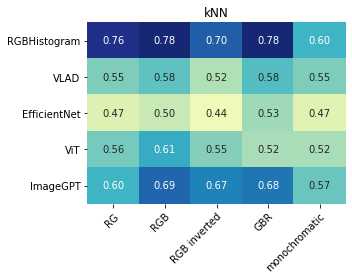

In [16]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(tbl,  cmap="YlGnBu", annot=True, fmt=".2f", vmin=0.40, vmax=0.80, cbar=False)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlabel("")
plt.ylabel("")
plt.title("kNN")
plt.tight_layout()

plt.savefig("knnResults.png",dpi=300)

## Baseline results (from external sources)
- see http://www.biointelligence.hu/typing-challenge/task2/leaderboard.php for details

In [121]:
dfBaselines = pd.DataFrame({"DTW distance":[0.601694915254, 0.639830508475, 0.699152542373, 0.52542372881356]}, index=["1NN","kNN","ECkNN","SUCCESS"])
dfBaselines

,DTW distance
1NN,0.601695
kNN,0.639831
ECkNN,0.699153
SUCCESS,0.525424


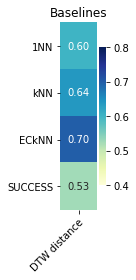

In [122]:
import seaborn as sns
plt.figure(figsize=(2,4))
sns.heatmap(dfBaselines,  cmap="YlGnBu", annot=True, fmt=".2f", vmin=0.40, vmax=0.80)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.yticks(rotation = 0, ha='right', rotation_mode='anchor')
plt.xlabel("")
plt.ylabel("")
plt.title("Baselines")
plt.tight_layout()

plt.savefig("baselineResults.png",dpi=300)

## Significance tests

In [31]:
resFiles = [f for f in listdir("../KeystrokeDynamics/") if (isfile(join("../KeystrokeDynamics/", f) ))]
resFiles = [f for f in resFiles if f.startswith("task2_")]
resFiles

['task2_HWkNN_blacks_extracted_EfficientNetExtractor_2__3_3_True_False.csv',
 'task2_HWkNN_blacks_extracted_ImageGPTExtractor_medium__1_3_True_False.csv',
 'task2_HWkNN_blacks_extracted_RGBHistogramExtractorGrid_32_1_3_5_True_False.csv',
 'task2_HWkNN_blacks_extracted_ViTExtractor_large__3_5_True_False.csv',
 'task2_HWkNN_blacks_extracted_VLADExctractor___5_5_True_False.csv',
 'task2_HWkNN_extracted_EfficientNetExtractor_2__5_3_True_False.csv',
 'task2_HWkNN_extracted_ImageGPTExtractor_medium__1_5_True_False.csv',
 'task2_HWkNN_extracted_RGBHistogramExtractorGrid_32_1_3_5_True_False.csv',
 'task2_HWkNN_extracted_ViTExtractor_large__1_5_True_False.csv',
 'task2_HWkNN_extracted_VLADExctractor___3_5_True_False.csv',
 'task2_HWkNN_inverted2_extracted_EfficientNetExtractor_2__7_5_True_False.csv',
 'task2_HWkNN_inverted2_extracted_ImageGPTExtractor_medium__1_3_True_False.csv',
 'task2_HWkNN_inverted2_extracted_RGBHistogramExtractorGrid_256_1_3_3_True_False.csv',
 'task2_HWkNN_inverted2_extra

In [53]:
def evaluateResults(results, trueLabels):
        
    jointDF = results
    jointDF = jointDF.join(trueLabels.set_index("record_id"), how="inner")
    jointDF["correct"] = (jointDF.record_id_predicted == jointDF.record_id_true)
      
    return jointDF["correct"]

In [54]:
resKNN = [f for f in resFiles if f.startswith("task2_KNN")]
resHWKNN = [f for f in resFiles if f.startswith("task2_HWkNN")]

In [59]:
knnTrue = 0
knnFalse = 0
for i in resKNN:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    knnTrue += (r==True).sum()
    knnFalse += (r==False).sum()

hwknnTrue = 0
hwknnFalse = 0
for i in resHWKNN:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    hwknnTrue += (r==True).sum()
    hwknnFalse += (r==False).sum() 
    
(knnTrue, knnFalse, hwknnTrue,hwknnFalse)

(3484, 2416, 3498, 2402)

In [74]:
from scipy.stats import fisher_exact
table= [[knnTrue,hwknnTrue],[knnFalse,hwknnFalse]]
fisher_exact(table, "less")

(0.9902262030526431, 0.40381799260305606)

In [62]:
testSetSIze = 236
ecknnTrue, ecknnFalse = round(0.699152542373 * testSetSIze), round((1-0.699152542373) * testSetSIze)

In [84]:
resRGBHist = [f for f in resFiles if "RGBHistogramExtractorGrid" in f]
vlad = [f for f in resFiles if "VLADEx" in f]
efnet = [f for f in resFiles if "Efficient" in f]
vit = [f for f in resFiles if "ViTExtr" in f]
igpt = [f for f in resFiles if "ImageGPT" in f]

resRGBHist_noBlack = [f for f in resRGBHist if not "blacks" in f]

In [92]:
resRGBHist

['task2_HWkNN_blacks_extracted_RGBHistogramExtractorGrid_32_1_3_5_True_False.csv',
 'task2_HWkNN_extracted_RGBHistogramExtractorGrid_32_1_3_5_True_False.csv',
 'task2_HWkNN_inverted2_extracted_RGBHistogramExtractorGrid_256_1_3_3_True_False.csv',
 'task2_HWkNN_inverted3_extracted_RGBHistogramExtractorGrid_64_1_3_5_True_False.csv',
 'task2_HWkNN_inverted_extracted_RGBHistogramExtractorGrid_32_1_3_5_True_False.csv',
 'task2_KNN_blacks_extracted_RGBHistogramExtractorGrid_32_1_3_True_False.csv',
 'task2_KNN_extracted_RGBHistogramExtractorGrid_32_1_3_True_False.csv',
 'task2_KNN_inverted2_extracted_RGBHistogramExtractorGrid_32_1_3_True_False.csv',
 'task2_KNN_inverted3_extracted_RGBHistogramExtractorGrid_64_1_3_True_False.csv',
 'task2_KNN_inverted_extracted_RGBHistogramExtractorGrid_32_1_3_True_False.csv']

In [86]:
rgbTrue = 0
rgbFalse = 0
for i in resRGBHist:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rgbTrue += (r==True).sum()
    rgbFalse += (r==False).sum()

vladTrue = 0
vladFalse = 0
for i in vlad:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    vladTrue += (r==True).sum()
    vladFalse += (r==False).sum()    

efnetTrue = 0
efnetFalse = 0
for i in efnet:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    efnetTrue += (r==True).sum()
    efnetFalse += (r==False).sum()       
    
vitTrue = 0
vitFalse = 0
for i in vit:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    vitTrue += (r==True).sum()
    vitFalse += (r==False).sum()  
    
igptTrue = 0
igptFalse = 0
for i in igpt:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    igptTrue += (r==True).sum()
    igptFalse += (r==False).sum()  
    
rgbnbTrue = 0
rgbnbFalse = 0
for i in resRGBHist_noBlack:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rgbnbTrue += (r==True).sum()
    rgbnbFalse += (r==False).sum() 
    
(rgbTrue, rgbFalse, rgbnbTrue,rgbnbFalse)

(1709, 651, 1422, 466)

In [87]:
from scipy.stats import fisher_exact
table= [[rgbTrue,vladTrue],[rgbFalse,vladFalse]]
fisher_exact(table, "greater")

(1.9003398715691653, 1.412727732118162e-25)

In [88]:
from scipy.stats import fisher_exact
table= [[rgbTrue,efnetTrue],[rgbFalse,efnetFalse]]
fisher_exact(table, "greater")

(2.9362560568328795, 8.567252657637143e-71)

In [89]:
from scipy.stats import fisher_exact
table= [[rgbTrue,vitTrue],[rgbFalse,vitFalse]]
fisher_exact(table, "greater")

(2.226376624360811, 2.6273947045949173e-39)

In [90]:
from scipy.stats import fisher_exact
table= [[rgbTrue,igptTrue],[rgbFalse,igptFalse]]
fisher_exact(table, "greater")

(1.4696217015258441, 5.161813611192857e-10)

In [75]:
from scipy.stats import fisher_exact
table= [[rgbnbTrue,ecknnTrue],[rgbnbFalse,ecknnFalse]]
fisher_exact(table, "greater")

(1.3130706203667577, 0.04428211332789193)

In [95]:
rgblacks = np.array(resRGBHist)[[0,5]]
rg1 = np.array(resRGBHist)[[1,6]]
rg2 = np.array(resRGBHist)[[2,7]]
rg3 = np.array(resRGBHist)[[3,8]]
rg4 = np.array(resRGBHist)[[4,9]]

In [97]:
rgblacksTrue = 0
rgblacksFalse = 0
for i in rgblacks:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rgblacksTrue += (r==True).sum()
    rgblacksFalse += (r==False).sum()
    
rg1True = 0
rg1False = 0
for i in rg1:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rg1True += (r==True).sum()
    rg1False += (r==False).sum()    
    
rg2True = 0
rg2False = 0
for i in rg2:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rg2True += (r==True).sum()
    rg2False += (r==False).sum()   
    
rg3True = 0
rg3False = 0
for i in rg3:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rg3True += (r==True).sum()
    rg3False += (r==False).sum()   
    
rg4True = 0
rg4False = 0
for i in rg4:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rg4True += (r==True).sum()
    rg4False += (r==False).sum()       

In [99]:
from scipy.stats import fisher_exact
table= [[rg1True,ecknnTrue],[rg1False,ecknnFalse]]
fisher_exact(table, "greater")

(1.4330275229357798, 0.028006646421128253)

In [100]:
from scipy.stats import fisher_exact
table= [[rg2True,ecknnTrue],[rg2False,ecknnFalse]]
fisher_exact(table, "greater")

(1.0, 0.5330988427404265)

In [101]:
from scipy.stats import fisher_exact
table= [[rg3True,ecknnTrue],[rg3False,ecknnFalse]]
fisher_exact(table, "greater")

(1.4857632933104632, 0.017763490751562833)

In [98]:
from scipy.stats import fisher_exact
table= [[rg4True,ecknnTrue],[rg4False,ecknnFalse]]
fisher_exact(table, "greater")

(1.4330275229357798, 0.028006646421128253)

In [102]:
from scipy.stats import fisher_exact
table= [[rgbnbTrue,rgblacksTrue],[rgbnbFalse,rgblacksFalse]]
fisher_exact(table, "greater")

(1.966996156779471, 5.337990131561319e-10)

In [105]:
blacks = [f for f in resFiles if "blacks_extracted" in f]
gbr = [f for f in resFiles if "inverted_extracted" in f]
irgb = [f for f in resFiles if "inverted2_extracted" in f]
rg = [f for f in resFiles if "inverted3_extracted" in f]
rgb = [f for f in resFiles if "N_extracted" in f]

['task2_HWkNN_inverted3_extracted_EfficientNetExtractor_2__7_3_True_False.csv',
 'task2_HWkNN_inverted3_extracted_ImageGPTExtractor_medium__1_5_True_False.csv',
 'task2_HWkNN_inverted3_extracted_RGBHistogramExtractorGrid_64_1_3_5_True_False.csv',
 'task2_HWkNN_inverted3_extracted_ViTExtractor_large__1_3_True_False.csv',
 'task2_HWkNN_inverted3_extracted_VLADExctractor___7_5_True_False.csv',
 'task2_KNN_inverted3_extracted_EfficientNetExtractor_2__3_True_False.csv',
 'task2_KNN_inverted3_extracted_ImageGPTExtractor_medium__1_True_False.csv',
 'task2_KNN_inverted3_extracted_RGBHistogramExtractorGrid_64_1_3_True_False.csv',
 'task2_KNN_inverted3_extracted_ViTExtractor_large__3_True_False.csv',
 'task2_KNN_inverted3_extracted_VLADExctractor___3_True_False.csv']

In [106]:
blacksTrue = 0
blacksFalse = 0
for i in blacks:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    blacksTrue += (r==True).sum()
    blacksFalse += (r==False).sum()
    
gbrTrue = 0
gbrFalse = 0
for i in gbr:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    gbrTrue += (r==True).sum()
    gbrFalse += (r==False).sum()    
    
irgbTrue = 0
irgbFalse = 0
for i in irgb:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    irgbTrue += (r==True).sum()
    irgbFalse += (r==False).sum() 
    
rgTrue = 0
rgFalse = 0
for i in rg:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rgTrue += (r==True).sum()
    rgFalse += (r==False).sum() 
    
rgbTrue = 0
rgbFalse = 0
for i in rgb:
    df_i = pd.read_csv(i, header=None, index_col=0)
    df_i.columns = ["record_id_predicted"]
    r = evaluateResults(df_i, trueLabels)
    rgbTrue += (r==True).sum()
    rgbFalse += (r==False).sum() 
    
  

In [107]:
from scipy.stats import fisher_exact
table= [[rgTrue,blacksTrue],[rgFalse,blacksFalse]]
fisher_exact(table, "greater")

(1.2220924195223262, 0.00036183304540996105)

In [108]:
from scipy.stats import fisher_exact
table= [[rgbTrue,blacksTrue],[rgbFalse,blacksFalse]]
fisher_exact(table, "greater")

(1.427394346847088, 1.1446196651967215e-09)

In [109]:
from scipy.stats import fisher_exact
table= [[irgbTrue,blacksTrue],[irgbFalse,blacksFalse]]
fisher_exact(table, "greater")

(1.1516262685145138, 0.008745635929542629)

In [110]:
from scipy.stats import fisher_exact
table= [[gbrTrue,blacksTrue],[gbrFalse,blacksFalse]]
fisher_exact(table, "greater")

(1.3234087465740598, 1.1924538693079224e-06)

In [113]:
rgTrue / (rgTrue+rgFalse),rgbTrue / (rgbTrue+rgbFalse),irgbTrue / (irgbTrue+irgbFalse),gbrTrue / (gbrTrue+gbrFalse),blacksTrue / (blacksTrue+blacksFalse)

(0.5932203389830508,
 0.6300847457627119,
 0.5788135593220339,
 0.6122881355932204,
 0.5440677966101695)

In [114]:
from scipy.stats import fisher_exact
table= [[rgbTrue,irgbTrue],[rgbFalse,irgbFalse]]
fisher_exact(table, "greater")

(1.239459697882967, 0.00017644112019415994)

In [115]:
from scipy.stats import fisher_exact
table= [[gbrTrue,irgbTrue],[gbrFalse,irgbFalse]]
fisher_exact(table, "greater")

(1.1491651265311347, 0.010347415564776084)

In [116]:
from scipy.stats import fisher_exact
table= [[gbrTrue,rgbTrue],[gbrFalse,rgbFalse]]
fisher_exact(table, "less")

(0.927150054571312, 0.10930140707091811)

In [117]:
from scipy.stats import fisher_exact
table= [[rgTrue,rgbTrue],[rgFalse,rgbFalse]]
fisher_exact(table, "less")

(0.8561701412239409, 0.005103744648880347)

In [118]:
from scipy.stats import fisher_exact
table= [[rgTrue,gbrTrue],[rgFalse,gbrFalse]]
fisher_exact(table, "less")

(0.9234429065743944, 0.09529337656940104)

In [120]:
from scipy.stats import fisher_exact
table= [[rgTrue,irgbTrue],[rgFalse,irgbFalse]]
fisher_exact(table, "greater")

(1.061188384577843, 0.1647291700614073)